# ELMo and BERT Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo/BERT to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import random
import scipy.stats

import src.corpus
import src.semantic_embedding

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Parse the corpus

In [2]:
UD_PATH = '../data/ud_all/ud-treebanks-v2.5/'
ud_files = src.corpus.group_treebanks_by_language(UD_PATH)
corpus = src.corpus.POSCorpus.create_from_ud(data_file_list=ud_files['English'])

#BNC_FILE = "../data/bnc/bnc.pkl"
#corpus = src.corpus.POSCorpus.create_from_bnc_pickled(data_file_path=BNC_FILE)

## Compute embeddings on random part of the corpus

In [3]:
# Take only 1M words out of 4M to make it run faster
SAMPLE_PROPORTION = 1.0
random.seed(12345)
random_indices = random.sample(range(len(corpus.sentences)), int(SAMPLE_PROPORTION * len(corpus.sentences)))

sampled_sentences = []
for ix in random_indices:
  sampled_sentences.append(corpus.sentences[ix])
  
embedder = src.semantic_embedding.SemanticEmbedding(sampled_sentences)
embedder.init_bert(model_name='bert-base-multilingual-cased', layer=12)

## Compute embeddings of instances of a fixed lemma

In [4]:
FIXED_LEMMA = "store"
noun_embeddings, verb_embeddings = embedder.get_bert_embeddings_for_lemma(FIXED_LEMMA)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Processing lemma: store (108 instances)
Noun instances: 91
Verb instances: 15


## Apply PCA and plot

In [5]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)

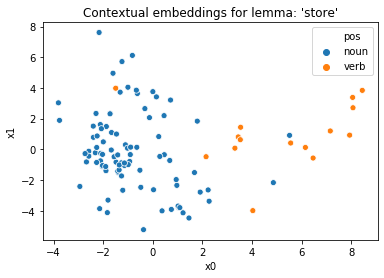

In [6]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="Contextual embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Utility to inspect what it's capturing

## Cosine similarity between noun and verb usages

In [7]:
lemma_count_df = corpus.get_per_lemma_stats()

# Filter: must have at least [x] noun and [x] verb usages
lemma_count_df = lemma_count_df[(lemma_count_df['noun_count'] >= 30) & (lemma_count_df['verb_count'] >= 30)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
#lemma_count_df = lemma_count_df[~lemma_count_df.lemma.isin(['go', 'will', 'may'])]
print('Remaining lemmas:', len(lemma_count_df))
print('Noun lemmas:', len(lemma_count_df[lemma_count_df.majority_tag == 'NOUN']))
print('Verb lemmas:', len(lemma_count_df[lemma_count_df.majority_tag == 'VERB']))

Remaining lemmas: 65
Noun lemmas: 35
Verb lemmas: 30


In [ ]:
lemma_count_df[['nv_cosine_similarity', 'n_variation', 'v_variation']] = \
  lemma_count_df.apply(lambda row: embedder.get_contextual_nv_similarity(row.lemma, method="bert"),
                       axis=1, result_type="expand")

In [9]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity', 'n_variation', 'v_variation']] \
  .sort_values('nv_cosine_similarity').head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity,n_variation,v_variation
3708,issue,171,32,NOUN,0.536880,6.698858,9.088453
482,state,220,53,NOUN,0.603530,9.007372,9.683029
3158,concern,57,41,NOUN,0.666435,7.046387,9.269892
157,base,41,120,VERB,0.666843,8.799785,8.997353
1013,force,101,44,NOUN,0.696499,8.436421,9.282113
2597,post,46,61,VERB,0.704809,7.884580,8.895184
869,play,67,160,VERB,0.706504,6.935749,9.764672
661,sign,50,76,VERB,0.709628,7.636377,8.864773


In [10]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity', 'n_variation', 'v_variation']] \
  .sort_values('nv_cosine_similarity', ascending=False).head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity,n_variation,v_variation
680,search,34,30,NOUN,0.935881,6.715807,6.835266
62,filter,60,40,NOUN,0.923524,6.272938,6.660912
956,answer,82,51,NOUN,0.907414,6.706615,8.059229
689,check,31,104,VERB,0.886386,6.373006,7.351769
128,return,46,129,VERB,0.880605,7.731968,8.830537
509,work,402,411,VERB,0.876613,8.436759,9.037231
2300,increase,36,78,VERB,0.875558,7.281770,8.843405
192,need,77,467,VERB,0.873682,8.270714,8.945591


## Difference in similarity when base is noun vs verb

/h/bai/moar/bai-conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


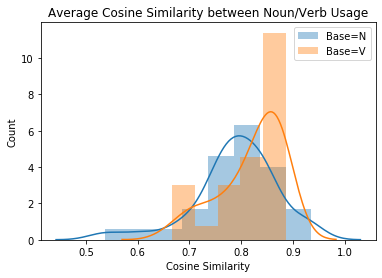

In [11]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity, label='Base=N')
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity, label='Base=V')
plt.legend()
plot.set(title="Average Cosine Similarity between Noun/Verb Usage",
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [12]:
print('Mean cosine similarity when Base=N:', np.mean(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity))
print('Mean cosine similarity when Base=V:', np.mean(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity))

Mean cosine similarity when Base=N: 0.7894658957208905
Mean cosine similarity when Base=V: 0.8200634996096293


In [13]:
# T-test of difference in mean
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity)

Ttest_indResult(statistic=-1.6827928462176236, pvalue=0.09736532173592662)

## Difference in variation between majority and minority class

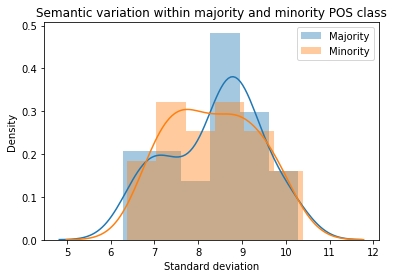

In [14]:
majority_variation = np.where(lemma_count_df.majority_tag == 'NOUN', lemma_count_df.n_variation, lemma_count_df.v_variation)
minority_variation = np.where(lemma_count_df.majority_tag == 'NOUN', lemma_count_df.v_variation, lemma_count_df.n_variation)
plot = sns.distplot(majority_variation, label='Majority')
plot = sns.distplot(minority_variation, label='Minority')
plt.legend()
plot.set(title="Semantic variation within majority and minority POS class",
         xlabel="Standard deviation", ylabel="Density")
plt.show()

In [15]:
print('Mean majority variation:', np.mean(majority_variation))
print('Mean minority variation:', np.mean(minority_variation))

Mean majority variation: 8.37774537893442
Mean minority variation: 8.330862918266883


In [16]:
# Paired t-test for difference
scipy.stats.ttest_rel(majority_variation, minority_variation)

Ttest_relResult(statistic=0.2660442328960784, pvalue=0.7910603542779546)